# Lab 4: Memory-Efficient Transformer Training Techniques

The goal of this assignment was to compare several modern memory-optimization techniques (BF16 mixed precision, FlashAttention, windowed attention and gradient checkpointing) used during Transformer training. The compared metrics include: GPU memory usage, maximum batch size that fits into memory, training speed (time per step and total time for 1 epoch) and final model performance (perplexity after 1 epoch).


### Datasets and Tokenizer

The datasets used were downloaded from Speakleash (only high-quality docs were used, resulting in ~25MB files each)
- `wolne_lektury_corpus` - for training  
- `1000_novels_corpus_CLARIN-PL` - for validation 

The SentencePiece tokenizer was used (trained on the training corpus). Vocabulary size: 12000.

Sequence Length was set to 256, and whole datasets were used, resulting in:
- Number of training sequences: 28049
- Number of validation sequences: 24965

The datasets and splits are kept identical across all techniques.

### Model architecture
The model used in all experiments is a small decoder-only Transformer inspired by the GPT architecture (from Lab 1). It consists of an embedding layer, sinusoidal positional encoding, a stack of Transformer decoder blocks, and a final linear language modeling head.

Token embeddings of dimension 128 are combined with positional encodings and passed through 4 identical decoder blocks. Each block contains a multi-head self-attention layer with 8 attention heads, followed by a position-wise feed-forward network with hidden dimension 1024. Layer normalization and residual connections are applied around both the attention and feed-forward sublayers. A dropout rate of 0.1 is used throughout the model.

The final layer normalisation is followed by a linear projection to the vocabulary size (12 000). The input embedding matrix and the output projection weights are tied. The model is trained in an autoregressive manner using causal masking, so each token can only attend to previous tokens in the sequence.

The architecture is kept identical across all experiments. Only memory-related training techniques (mixed precision, FlashAttention, windowed attention, and gradient checkpointing) are enabled or disabled via configuration flags.

In [9]:
import sys
from pathlib import Path

repo_root = Path("..").resolve()
sys.path.insert(0, str(repo_root))


import config
from model import TransformerDecoderOnly

model = TransformerDecoderOnly(
    vocab_size=config.VOCAB_SIZE,
    d_model=config.TX_D_MODEL,
    n_layer=config.TX_N_LAYER,
    n_head=config.TX_N_HEAD,
    d_ff=config.TX_D_FF,
    dropout=config.TX_DROPOUT,
    pad_id=3,
)

model

TransformerDecoderOnly(
  (embed): Embedding(12000, 128, padding_idx=3)
  (posenc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blocks): ModuleList(
    (0-3): 4 x DecoderBlock(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=128, bias=True)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=12000, bias=False)
)

In [10]:
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

Total Parameters: 2,855,680


Training hyperparameters (the setup can be found in `config.py`):
- Learning rate: 1e-3
- Optimizer: Adam
- Number of epochs: just 1 for profiling different training regimes
- Gradient clipping: 0.5
- random seed was added (9) so runs are reproducible and results comparable (in terms of PPL for example especially after just onen epoch)
- the `torch.Generator()` was used to ensure the same dataset splits in Dataloaders

### Model/Training changes for different memory optimisation techniques 

#### BF16 Automatic Mixed Precision
The following block was added to the forward pass in `train.py` to enable automatic mixed precision optimisation: 
```python
if config.USE_BF16:
            with torch.amp.autocast("cuda", dtype=torch.bfloat16):
```

- It causes selected operations in the forward pass to be executed in bfloat16 instead of full precision, which reduces memory usage and changes the numerical precision used during training, while the rest of the computation remains in full precision.

#### FlashAttention and Windowed (Local) Attention
FlashAttention was installed using `FA_setup` following the docs https://github.com/Dao-AILab/flash-attention

The self-attention computation in `DecoderBlock` (in `model.py`) was modified to optionally use FlashAttention instead of PyTorch’s standard MultiheadAttention: 
```python
    if getattr(config, "USE_FLASH", False):
    attn_out = self._flash_attention(x, key_padding_mask=key_padding_mask)
else:
    attn_out, _ = self.self_attn(
        x, x, x,
        attn_mask=attn_mask,
        key_padding_mask=key_padding_mask,
        need_weights=False,
    )
```

Inside `_flash_attention`, queries, keys, and values are computed explicitly using the existing projection weights and passed to `flash_attn_func` with causal masking enabled:
```python
attn_out = flash_attn_func(
    q, k, v,
    dropout_p=dropout_p,
    causal=True,
    window_size=window_size,
)

```
- FlashAttention computes self-attention using a fused CUDA kernel that avoids materialising the full attention matrix. This reduces memory usage and often improves runtime, especially for longer sequences, while preserving exact attention results.
- Windowed (local) attention restricts each token to attend only to a fixed number of previous tokens (defined by window_size), instead of the entire sequence. This further reduces memory and computation at the cost of limiting long-range context.

The original model architecture and parameters are preserved, and the window size can be configured without changing the rest of the training pipeline.


#### Gradient Checkpointing
The for loop over blocks in the forward pass in `TransformerDecoderOnly` class in `model.py` was changed to:

```python
for blk in self.blocks:
            # this adds gradient checkpointing
            if getattr(config, "USE_CKPT", False) and self.training:
                # checkpoint requires a function whose *inputs are tensors*
                def custom_forward(h_):
                    return blk(h_, attn_mask=attn_mask, key_padding_mask=key_padding_mask)

                h = checkpoint(custom_forward, h, use_reentrant=False)
            else:
                h = blk(h, attn_mask=attn_mask, key_padding_mask=key_padding_mask)
```
- It avoids storing intermediate activations for each decoder block during training and recomputes them during backpropagation, trading increased computation time for reduced memory usage.

### Hardware used

- Experiments were conducted on the Athena HPC cluster at AGH University of Science and Technology. 
- The SLURM scheduller was used and the script `training.sh` was used to run the experiment setup from `run_baseline.py`.
- All experiments were run on a single NVIDIA A100-SXM4 GPU with 40 GB HBM2 memory.
- The training stack used PyTorch 2.5.1 with CUDA 12.1 and FlashAttention 2.8.3.
- The GPU natively supports BF16 mixed-precision arithmetic.

```
=== Hardware summary ===

GPU: NVIDIA A100-SXM4-40GB
GPU memory (GB): 39.7
PyTorch: 2.5.1+cu121
CUDA (torch): 12.1
BF16 supported: True

Name: flash_attn
Version: 2.8.3
```


### Experiment setup
- See `run_baseline.py` for a full experiment setup implementation
- The different techniques are executed by setting flags in `__main__`
- For each technique, two configurations were run: 
    - (1) using the same batch size as the FP32 baseline, and 
    - (2) using the maximum batch size that fits into GPU memory (tested when increasing until OOM)
    ```python
    TECHNIQUES = [
        {"name": "fp32", "amp_bf16": False, "flash": False, "window": None, "ckpt": False},         # 0.
        {"name": "bf16", "amp_bf16": True,  "flash": False, "window": None, "ckpt": False},         # 1.
        {"name": "fa2",  "amp_bf16": True,  "flash": True,  "window": None, "ckpt": False},         # 2.
        {"name": "fa2_win128", "amp_bf16": True, "flash": True, "window": 128, "ckpt": False},      # 3.
        {"name": "fa2_win256", "amp_bf16": True, "flash": True, "window": 128, "ckpt": False},      # 3.
        {"name": "fp32_ckpt", "amp_bf16": False, "flash": False, "window": None, "ckpt": True},     # 4.
        {"name": "bf16_ckpt", "amp_bf16": True, "flash": False, "window": None, "ckpt": True},      # 4.
    ]
    ```
- two helper functions were added to `benchmark_utils.py` - `find_max_batch_size` and `profile_one_training_step`
- peak memory usage and average step time are measured over 20 training steps (including warmup)
    ```python
    train_iter = iter(train_loader)
    for _ in range(20):
        batch = next(train_iter)
        step_t, mem_fwd, mem_bwd, peak_m = profile_one_training_step(
            model, optimizer, criterion, batch, device
        )
        step_times.append(step_t)
        mem_forwards.append(mem_fwd)
        mem_backwards.append(mem_bwd)
        peak_mems.append(peak_m)

    mean_step_time = sum(step_times) / len(step_times)
    mem_forward = sum(mem_forwards) / len(mem_forwards)
    mem_backward = sum(mem_backwards) / len(mem_backwards)
    peak_memory = max(peak_mems)
    ```
- training time and perplexity are measured after one full epoch (using `train_epoch` and `evaluate` functions from `train.py`)
    ```python
    train_loss, epoch_time = train_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_ppl = evaluate(
        model, val_loader, criterion, device
    )
    ```
- all metrics were saved to csv files
- other variables (such as dataset split, seq len, model dims, optimizer, epochs=1, seed, etc. were kept identical across runs)

# Results

In [ ]:
import pandas as pd
from pathlib import Path

BENCH_DIR = Path("./logs")

csv_files = sorted(
    BENCH_DIR.glob("benchmark_*.csv"),
    key=lambda p: p.stat().st_mtime  # order by file modification time
)

rows = []

for csv_path in csv_files:
    df = pd.read_csv(csv_path)
    row = df.iloc[0].to_dict()

    name = csv_path.stem.replace("benchmark_", "")
    
    if name.endswith("_same_bs"):
        run_type = "same_bs"
        technique = name.replace("_same_bs", "")
    elif name.endswith("_max"):
        run_type = "max"
        technique = name.replace("_max", "")
    else:
        continue

    row.update({
        "technique": technique,
        "run_type": run_type,
        "file": csv_path.name,
    })
    rows.append(row)

results = pd.DataFrame(rows)

# ---------- FORMAT + SELECT REQUIRED METRICS ----------

results["max_batch_size"] = results["max_batch_size"].astype(int)

results["peak_mem_gb"] = (results["peak_mem_mb"] / 1024).round(2)

results["mean_step_time_sec"] = results["mean_step_time_sec"].round(3)

results["epoch_time_sec"] = results["epoch_time_sec"].round(2)

results["val_perplexity"] = results["val_perplexity"].apply(
    lambda x: f"{float(x):.2e}"
)

comparison_table = results[
    [
        "technique",
        "run_type",
        "max_batch_size",
        "peak_mem_gb",
        "mean_step_time_sec",
        "epoch_time_sec",
        "val_perplexity",
    ]
]

comparison_table


,technique,run_type,max_batch_size,peak_mem_gb,mean_step_time_sec,epoch_time_sec,val_perplexity
0,fp32,max,496,32.97,0.255,16.04,1.23e+07
1,bf16,same_bs,496,22.55,0.137,9.19,1.22e+07
2,bf16,max,512,23.27,0.134,10.01,9.05e+06
3,fa2,same_bs,496,20.49,0.098,8.77,1.53e+07
4,fa2,max,896,36.96,0.165,7.39,4.97e+08
5,fa2_win128,same_bs,496,20.49,0.106,7.23,1.12e+07
6,fa2_win128,max,896,36.96,0.168,7.06,4.43e+08
7,fa2_win256,same_bs,496,20.49,0.096,7.10,1.12e+07
8,fa2_win256,max,896,36.96,0.167,6.98,4.43e+08
9,fp32_ckpt,same_bs,496,23.14,0.333,19.17,1.24e+07



### Batch Size and Perplexity
- Increasing batch size to the maximum fitting into memory often led to substantially worse validation perplexity (e.g. **2.69e+09** for `bf16_ckpt_max` compared to **1.23e+07** for the FP32 baseline).
- Since the dataset size was fixed (~28k sequences) and training was limited to a single epoch, larger batch sizes resulted in fewer optimizer updates.
- Without adjusting the learning rate or increasing the number of epochs, the model underfit, which explains the degraded perplexity.
- This shows that “maximum batch size fitting into memory” does not necessarily correspond to a practically useful training configuration when other hyperparameters remain unchanged.

### Final remarks
- For this model and sequence length, **BF16 combined with FlashAttention** provided the best overall trade-off between memory usage, training speed, and model performance.
- Gradient checkpointing is most useful when memory is the main constraint, but it introduces a clear performance penalty.
- Simply maximizing batch size to fill GPU memory is not sufficient; learning rate and training duration need to be adjusted accordingly to maintain model quality.

In [38]:
from matplotlib import pyplot as plt

plot_df = results[results["run_type"] == "same_bs"].copy()
fp32_row = results[(results["technique"] == "fp32")].copy()
plot_df = pd.concat([plot_df, fp32_row], ignore_index=True)

order = [
    "fp32",
    "bf16",
    "fa2",
    "fa2_win128",
    "fa2_win256",
    "fp32_ckpt",
    "bf16_ckpt",
]

plot_df["technique"] = pd.Categorical(
    plot_df["technique"],
    categories=order,
    ordered=True
)
plot_df = plot_df.sort_values("technique")


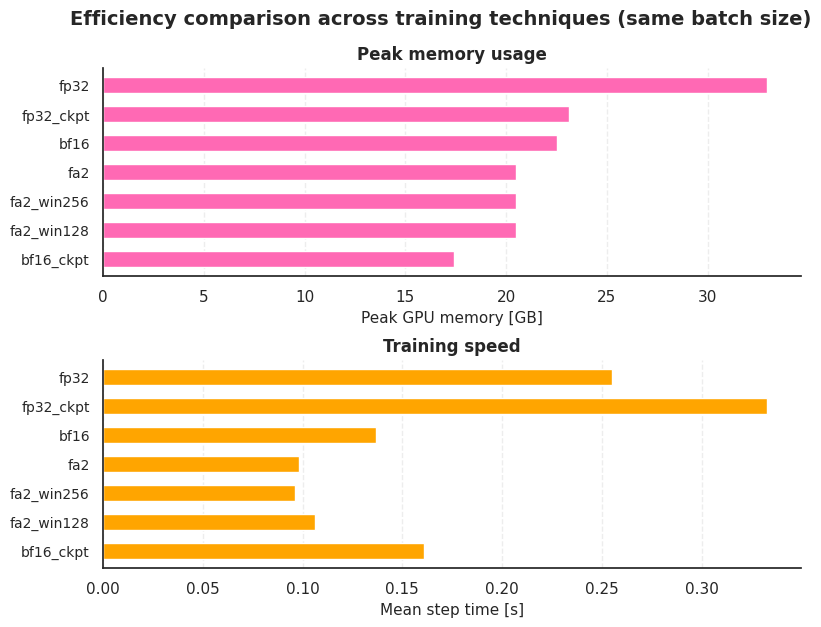

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_theme(style="white")

plot_df = plot_df.sort_values("peak_mem_gb", ascending=True)

fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(9, 6.5),
    gridspec_kw={"hspace": 0.4}
)

# ---- Peak memory ----
axes[0].barh(
    plot_df["technique"],
    plot_df["peak_mem_gb"],
    color="hotpink",
    height=0.55
)
axes[0].set_xlabel("Peak GPU memory [GB]", fontsize=11)
axes[0].set_title("Peak memory usage", fontsize=12, weight="semibold")

# ---- Step time ----
axes[1].barh(
    plot_df["technique"],
    plot_df["mean_step_time_sec"],
    color="orange",
    height=0.55
)
axes[1].set_xlabel("Mean step time [s]", fontsize=11)
axes[1].set_title("Training speed", fontsize=12, weight="semibold")

# ---- Aesthetics ----
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="x", linestyle="--", alpha=0.35)
    ax.grid(axis="y", visible=False)
    ax.tick_params(axis="y", labelsize=10)

fig.suptitle(
    "Efficiency comparison across training techniques (same batch size)",
    fontsize=14,
    weight="bold",
    y=0.97
)

plt.show()


## Comments and conclusions

### BF16 Automatic Mixed Precision
- Switching from FP32 to BF16 reduced peak memory usage (from **32.97 GB** to **22.55 GB** for the same batch size), which is roughly a 30% reduction.
- Training speed improved noticeably: mean step time dropped from **0.255s** (FP32) to **0.137s** (BF16) for the same batch size.
- Final validation perplexity remained very close to the FP32 baseline (around **1.2e+07** in both cases), suggesting that reduced precision did not noticeably affect model quality in this setup.
- Overall, BF16 appears to be a low-risk optimization that improves both memory usage and speed on the used hardware.

### FlashAttention and Windowed Attention
- FlashAttention (`fa2`) achieved the lowest peak memory usage among non-checkpointed runs (**20.49 GB**) and the fastest mean step time (**0.098s**) for the same batch size.
- Compared to BF16 alone, FlashAttention further reduced memory usage and improved training speed, while maintaining comparable validation perplexity.
- The windowed variants (`fa2_win128`, `fa2_win256`) did not reduce memory usage further compared to standard FlashAttention.
- I realised that setting the window size to 256 was effectively the same as not using windowing since it is identical to the set SEQ_LEN.
- For `window=128`, the mean step time was slightly higher than for global FlashAttention (0.106s vs 0.098s), indicating additional overhead.
- This suggests that for short sequences, the overhead of applying a sliding window outweighs any computational savings from reduced attention scope.
- These results are consistent with the expectation that windowed attention is mainly beneficial for much longer sequences, where full self-attention becomes a bottleneck.

### Gradient Checkpointing
- Gradient checkpointing significantly reduced memory usage, especially when combined with BF16 (down to **17.43 GB** for the same batch size).
- It enabled the largest maximum batch size observed in the experiments (**1024** in the `bf16_ckpt` run).
- This memory saving came at the cost of increased computation time: in FP32, enabling checkpointing increased mean step time from **0.255s** to **0.333s**, and epoch time increased accordingly.
- The slowdown is expected, as intermediate activations are recomputed during the backward pass instead of being stored.

### Batch Size and Perplexity
- Increasing batch size to the maximum fitting into memory often led to substantially worse validation perplexity (e.g. **2.69e+09** for `bf16_ckpt_max` compared to **1.23e+07** for the FP32 baseline).
- Since the dataset size was fixed (~28k sequences) and training was limited to a single epoch, larger batch sizes resulted in fewer optimizer updates.
- Without adjusting the learning rate or increasing the number of epochs, the model underfit, which explains the degraded perplexity.
- This shows that “maximum batch size fitting into memory” does not necessarily correspond to a practically useful training configuration when other hyperparameters remain unchanged.

### Final remarks
- For this model and sequence length, **BF16 combined with FlashAttention** provided the best overall trade-off between memory usage, training speed, and model performance.
- Gradient checkpointing is most useful when memory is the main constraint, but it introduces a clear performance penalty.
- Simply maximizing batch size to fill GPU memory is not sufficient; learning rate and training duration need to be adjusted accordingly to maintain model quality.
